# Investigation the effect of anti-PD1 on T cells

In [368]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *
from statsmodels.stats.weightstats import ztest
import scanpy as sc
import anndata
import warnings 
warnings.filterwarnings("ignore")


In [369]:
### HELPER FUNCTIONS ###

def fraction_test(df_expression, FEATURE, gene, cell_type):
    # return pval
    
    values_in_feature = list(set(df_expression[FEATURE]))
    if len(values_in_feature) < 2:
        print(f'no cells in one of the groups for: {gene}, {cell_type}')
        return 1
    val_1 = values_in_feature[0]
    val_2 = values_in_feature[1]
    
    if len(df_expression[df_expression[FEATURE]==val_1])<=5 or len(df_expression[df_expression[FEATURE]==val_2])<=5:
        return 1
    df_expression['is_expressing'] = df_expression.exp >2.5
    fractions = df_expression.groupby(['sample', FEATURE])['is_expressing'].agg(['sum', 'count']).reset_index()
    fractions['fractions'] = fractions['sum']/fractions['count']
    statistic, pvalue = ranksums(fractions[fractions[FEATURE]==val_2].fractions, fractions[fractions[FEATURE]==val_1].fractions)
    return pvalue

def Z_TEST(df_expression, FEATURE, gene, cell_type):
    # return pval
    values_in_feature = list(set(df_expression[FEATURE]))
    if len(values_in_feature) < 2:
        print(f'no cells in one of the groups for: {gene}, {cell_type}')
        return 1
    val_1 = values_in_feature[0]
    val_2 = values_in_feature[1]
    
    if len(df_expression[df_expression[FEATURE]==val_1])<=5 or len(df_expression[df_expression[FEATURE]==val_2])<=5:
        return 1
    statistic, pvalue = ztest(res_df[df_expression[FEATURE]==val_1].exp, df_expression[res_df[FEATURE]==val_2].exp, value=0) 
    return pvalue

def fisher_test(df_expression, FEATURE, gene, cell_type):

    values_in_feature = list(set(df_expression[FEATURE]))
    if len(values_in_feature) < 2:
        print(f'no cells in one of the groups for: {gene}, {cell_type}')
        return 1
    val_1 = values_in_feature[0]
    val_2 = values_in_feature[1]

    
    if len(df_expression[df_expression[FEATURE]==val_1])<=5 or len(df_expression[df_expression[FEATURE]==val_2])<=5:
        return 1
    df_expression['is_expressing'] = df_expression.exp >2.5

    n_cells_expressing = df_expression.groupby(FEATURE)['is_expressing'].sum()
    n_cells = df_expression.groupby(FEATURE)['is_expressing'].count()

    R_n_cells_expressing = n_cells_expressing[val_1]
    NR_n_cells_expressing = n_cells_expressing[val_2]
    R_n_cells_not_expressing = n_cells[val_1] - R_n_cells_expressing
    NR_n_cells_not_expressing = n_cells[val_2] - NR_n_cells_expressing

    import scipy.stats as stats
    oddsratio, pvalue = stats.fisher_exact([[R_n_cells_expressing, NR_n_cells_expressing],
                                            [R_n_cells_not_expressing, NR_n_cells_not_expressing]])
    return pvalue

# The rule is * for p<0.05, ** for p<0.005 and *** for p<0.0005.

def get_pval_symbol(p):
    if p<0.0005:
        return '***'
    elif p<0.005:
        return '**'
    elif p<0.05:
        return '*'
    else:
        return ''

# Extract cohort

In [3]:
data_path = r'/storage/md_keren/shitay/Data/smart_seq/SmartSeq_RNAseq_DATA.p'
cells, gene_names, patients_information = extract_smart_seq_data_from_pickle(data_path)

from utilities.smart_seq_dataset import RNAseq_Dataset
cohort = RNAseq_Dataset(cells, patients_information, gene_names)

# Builds gene list

In [4]:
### Prob: TNFA appears as TNF

genes = ['CCR8',  'CXCR3', 'CCL1', 'CXCL11', 'CXCL10', 'CXCL9', 'IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2']
gene_indices = [cohort.gene_names.index(gg) for gg in genes]

In [5]:
from anndata import AnnData
annCohort = AnnData(cohort.cells)

In [6]:
annCohort.var['gene'] = cohort.gene_names

annCohort.obs['sample'] = [cell.patient_details for cell in cohort.cells_information_list] 
annCohort.obs['barcode'] = [cell.cell_id for cell in cohort.cells_information_list] 
annCohort.obs['cell_type'] = [cell.supervised for cell in cohort.cells_information_list] 
annCohort.obs['response'] = [cell.response for cell in cohort.cells_information_list] 
annCohort.obs['pre/post'] = [p.split('_')[0] for p in annCohort.obs['sample'].values.tolist()]

14.12.21 update - last meeting with Nathi, he said that it might be that our definition of DC is slighly different than the definition in Luster's paper and therefore we would like to add those cells to our list.
We will look at cells that express CD103 (ITGAE), and simply call them CD103+:

In [7]:
### Mark cells as CD103+ is they express CD103
MIN_EXP_THRESHOLD = 2.5
CD103_index = annCohort.var.gene.tolist().index('ITGAE') #.index('CD103')
annCohort.obs['CD103+'] = annCohort.X[:,CD103_index] > MIN_EXP_THRESHOLD

### Mark cells as myeloid if their cell type is myeloid
MYELOID_CELL_TYPES = ['Macrophage_immature', 'Macrophage_mature', 'Monocyte_immature', 'Monocyte_mature', 'cDCs_dendritic_cells', 
 'pDCs', 'myeloid cells_general_immature', 'myeloid cells_general_mature', 'Neutrophils', 'Granolocytes']
def is_overlap(l1 , l2):
    return len([f for f in l1 if f in l2])!=0
annCohort.obs['is_myeloid'] = annCohort.obs['cell_type'].apply(lambda x: is_overlap(x, MYELOID_CELL_TYPES))


### Update cell type list
def add_pos_CD103_in_df(x):
    if x['CD103+'] and x['is_myeloid']:
        return x['cell_type'] + ['CD103+']
    else:
        return x['cell_type'] 

annCohort.obs['cell_type'] = annCohort.obs.apply(lambda x: add_pos_CD103_in_df(x), axis=1)

Takes interesting cell types

In [8]:
cell_types = list(set(flatten_list(annCohort.obs['cell_type'].tolist())))
t_cell_types = [ct for ct in cell_types if 'T' in ct]
not_t_cell_types = [ct for ct in cell_types if not ct in t_cell_types]

# Part 1: statiscal tests of cell-types expressing different genes

#### Plots all genes all cell types (T lineage)

Specify statistical test:

In [9]:
TEST_NAME = 'FISHER' # FRACTION/Z/FISHER


if TEST_NAME=='FRACTION':
    stat_test = fraction_test
elif TEST_NAME=='Z':
    stat_test = Z_TEST
elif TEST_NAME=='FISHER':
    stat_test = fisher_test
else:
    raise Exception('statistical name is not valid, change it')


Specify feature of intereset (R vs NR or pre vs post):

In [10]:
FEATURE = 'response' # "response" or "pre/post"

For the other feature (response/biopsy time) that you didn't perform the comparison on, 
if you want to filter only R/NR if you chose to compare biopsy time or alternatively to filter only pre/post if you chose response
you can do it here by setting the value of the variable filter_type:

None - will not filter.

1 - 'Responder'/'Pre' (will take 'Responder' if you compare biopsy time, and will take 'Pre' if you compare between response) 

2 - 'Non-Responder'/'Post' (will take 'Non-responder' if you compare biopsy time, and will take 'Post' if you compare between response) 


In [11]:
filter_type = None

filter_dic = {'response': {1: 'Responder', 2: 'Non-responder'}, 'pre/post': {1: 'Pre', 2:'Post'}}
filter_feature_dic = {'response': 'pre/post', 'pre/post': 'response'} # take by reverse

filtered_cohort = annCohort
if filter_type:
    FILTER_FEATURE = filter_feature_dic[FEATURE]
    print(f'gonna filter {FILTER_FEATURE}')
    filter_feature_req_value = filter_dic[FILTER_FEATURE][filter_type]
    filtered_cohort = annCohort[annCohort.obs[FILTER_FEATURE] == filter_feature_req_value]
    print(f'took only {filter_feature_req_value} samples')

else:
    print(f'did not filter')
print(f'cohort for comparison details:')
print(filtered_cohort)

did not filter
cohort for comparison details:
AnnData object with n_obs × n_vars = 16291 × 20214
    obs: 'sample', 'barcode', 'cell_type', 'response', 'pre/post', 'CD103+', 'is_myeloid'
    var: 'gene'


Specify whether you want to test T cells all all other cell-types:

In [12]:
TO_TEST_T_CELLS = False # True - t cells \ False - not t cells - all other


if TO_TEST_T_CELLS:
    CELL_TYPES = t_cell_types
else:
    CELL_TYPES = not_t_cell_types
    
### Takes only cell types that appear in filted_cohort
CELL_TYPES = [ct for ct in CELL_TYPES if ct in list(set(flatten_list(filtered_cohort.obs['cell_type'].tolist())))]

Conduct statistical tests for all genes X cell-types:

In [13]:
### builds DFs of all genes X cell types and conduct Z test:
df_gene_list = {}
for gene_idx, gene in enumerate(genes):
    g_cohort = filtered_cohort[:,  filtered_cohort.var['gene']==gene]
    f_df = pd.DataFrame(columns=['barcode', 'gene expression', 'cell type', FEATURE])
    df_gene_list[gene] = []
    for idx, cell_type in enumerate(CELL_TYPES):
        indices = [cell_type in ttt for ttt in g_cohort.obs['cell_type']]
        fg_cohort = g_cohort[indices, :]
        gene_exps = fg_cohort.X[:,0].tolist()
        feature_values = fg_cohort.obs[FEATURE].tolist()
        barcodes = fg_cohort.obs['barcode'].tolist()
        samples = fg_cohort.obs['sample'].tolist()

        ### statistical test of gene expression R/NR
        res_df = pd.DataFrame(transpose_list([samples, feature_values, gene_exps]), columns=['sample', FEATURE, 'exp'])
        pvalue = stat_test(res_df, FEATURE, gene, cell_type)
    
        df_gene_list[gene].append([pd.DataFrame(np.array([barcodes, gene_exps, [cell_type]*fg_cohort.shape[0], feature_values]).T, columns=f_df.columns), pvalue])
        
fig, axs = plt.subplots(len(genes))
fig.set_size_inches(32, 30)

### Correct pvals of all [genes X cell_types]
corrected_pvals = multipletests_fdr(np.array([pp[1]for ct_dfs in df_gene_list.values() for pp in ct_dfs ]))[1].reshape(len(genes), len(CELL_TYPES))

### For each gene prints all cell types:
my_pal = {"Responder": "b", "Non-responder": "r", "Pre":"r", "Post":"b"}
for gene_idx, gene in enumerate(genes):
    print_df = pd.DataFrame(columns=['barcode', 'gene expression', 'cell type', FEATURE])
    for cell_idx, cell_type in enumerate(CELL_TYPES):
        cell_type_df = df_gene_list[gene][cell_idx][0]
        prev_pval = df_gene_list[gene][cell_idx][1]
        corrected_pval = corrected_pvals[gene_idx][cell_idx]
        cell_type_df['cell type'] = cell_type_df['cell type'].iloc[0]+'\n'+ get_pval_symbol(corrected_pval)
        print_df = print_df.append(cell_type_df)

    print_df['gene expression'] = print_df['gene expression'].astype(float)
    g = sns.boxplot(ax=axs[gene_idx], x='cell type', y='gene expression', hue=FEATURE, data=print_df, palette=my_pal).set(title=gene)

if filter_type:
    fig.suptitle(f'Comparing {FEATURE}, only \'{filter_feature_req_value}\' samples were taken, statistical_test={TEST_NAME}', fontsize=32)
else:
    fig.suptitle(f'Comparing {FEATURE}, statistical_test={TEST_NAME}', fontsize=32)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Save fig output:

In [232]:
OUTPUT_FOLDER = r'/storage/md_keren/shitay/Nathi_project/differential analysis/14.12.21' 

if TO_TEST_T_CELLS:
    p_folder = 'T_cells'
else: p_folder = 'other_cells'
create_folder(join(OUTPUT_FOLDER, p_folder))

# folder = FEATURE.replace('/', '_').replace('response', 'R_NR')
test_n = TEST_NAME.lower().replace('fraction','ranksum')
feature_converted = FEATURE.replace('/', '_vs_')
file_name = fr'{p_folder.lower()}_{feature_converted}_comparison'
if filter_type:
    file_name += f'_{filter_feature_req_value}_samples'
file_name += f'_{test_n}_test.png'
FULL_OUTPUT_PATH = join(OUTPUT_FOLDER, p_folder, file_name)
print(f'Will be saved in {FULL_OUTPUT_PATH}')
fig.savefig(FULL_OUTPUT_PATH)

Will be saved in /storage/md_keren/shitay/Nathi_project/differential analysis/14.12.21/other_cells/other_cells_response_comparison_fisher_test.png


### You can check specific cases here.
Enter cell-type and gene and see the percentage of cells expressing the gene.

_FEATURE is the feature of the comparison: response or pre/post

use filter_type to filter the other feature you do not use for the comparison:

None - will not filter.

1 - 'Responder'/'Pre' (will take 'Responder' if you compare biopsy time, and will take 'Pre' if you compare between response) 

2 - 'Non-Responder'/'Post' (will take 'Non-responder' if you compare biopsy time, and will take 'Post' if you compare between response) 

In [15]:
gene = 'CXCR3' 
cell_type = 'T cells'
_FEATURE = 'pre/post' # "response" or "pre/post"
filter_type = None

sub_cohort = annCohort[indices]
filter_dic = {'response': {1: 'Responder', 2: 'Non-responder'}, 'pre/post': {1: 'Pre', 2:'Post'}}
filter_feature_dic = {'response': 'pre/post', 'pre/post': 'response'} # take by reverse

if filter_type:
    FILTER_FEATURE = filter_feature_dic[_FEATURE]
    print(f'gonna filter {FILTER_FEATURE}')
    filter_feature_req_value = filter_dic[FILTER_FEATURE][filter_type]
    sub_cohort = sub_cohort[sub_cohort.obs[FILTER_FEATURE] == filter_feature_req_value]
    print(f'took only {filter_feature_req_value} samples')

else:
    print(f'no filter was added')
gene_exp_threshold = 2.5
gene_index = sub_cohort.var.gene.tolist().index(gene)
indices = [cell_type in ttt for ttt in annCohort.obs['cell_type']]
gene_exps = sub_cohort.X[:,gene_index] > gene_exp_threshold

dd = pd.DataFrame(transpose_list([sub_cohort.obs[_FEATURE].tolist(), gene_exps]))
v1 = list(set(sub_cohort.obs[_FEATURE]))[0]
v2 = list(set(sub_cohort.obs[_FEATURE]))[1]

print(f'{v1}: ', round(dd[dd[0]==v1][1].sum() / dd[dd[0]==v1][1].count(), 3), f' of {cell_type} express {gene}')
print(f'{v2}: ', round(dd[dd[0]==v2][1].sum() / dd[dd[0]==v2][1].count(), 3), f' of {cell_type} express {gene}')

no filter was added
Pre:  0.303  of T cells express CXCR3
Post:  0.369  of T cells express CXCR3


# Part 2: tSNE of gene expression and cell-types
tSNE of requested genes and CD8\4 presentation

In [370]:
my_df = pd.DataFrame(cohort.cells, columns=cohort.gene_names)
data = anndata.AnnData(my_df)

In [371]:
sc.tl.pca(data)
sc.pp.neighbors(data)
sc.tl.tsne(data)

In [372]:
# adata.obs.loc[male_patients, 'sex'] = 'male'
CD8 = cohort.cells_information_list.get_cells_belong_to_cells_type('CD8 Cytotoxic T cells')
CD4 = cohort.cells_information_list.get_cells_belong_to_cells_type('CD4 helper T cells')
CD103_pos = ['CD103+' in ff for ff in annCohort.obs.cell_type]
data.obs.loc[CD103_pos, 'CD103+'] = 1
data.obs.loc[CD8, 'CD8 Cytotoxic T cells'] = 1
data.obs.loc[CD4, 'CD4 helper T cells'] = 1

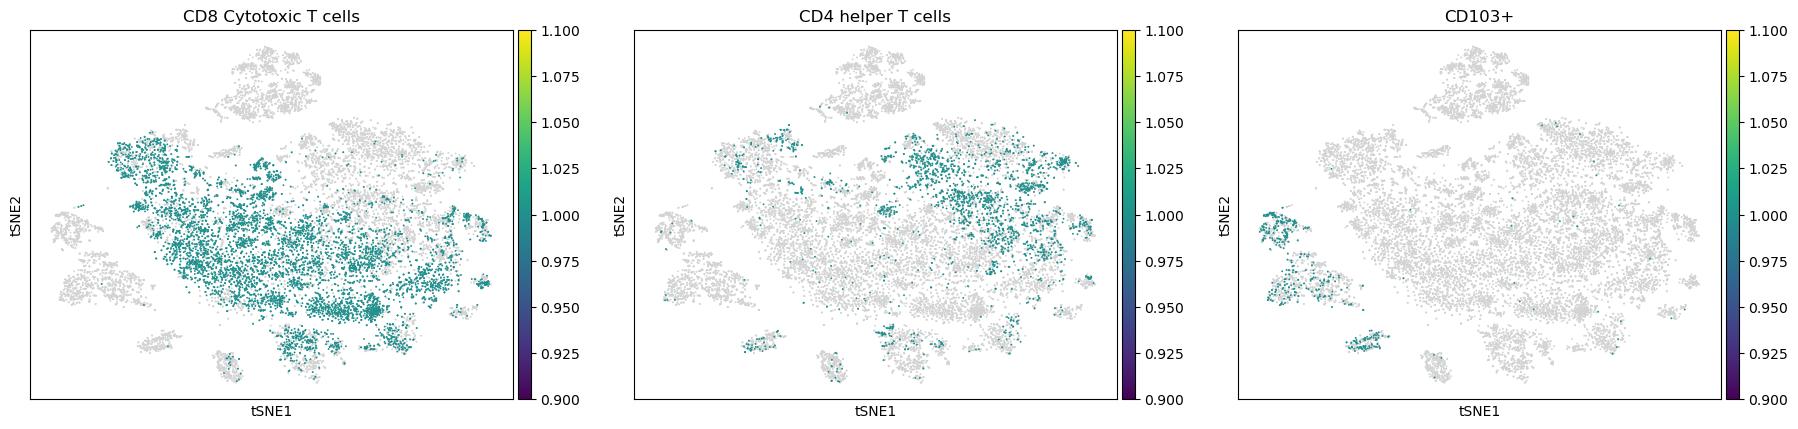

In [373]:
sc.pl.tsne(data, color = ['CD8 Cytotoxic T cells', 'CD4 helper T cells', 'CD103+'])

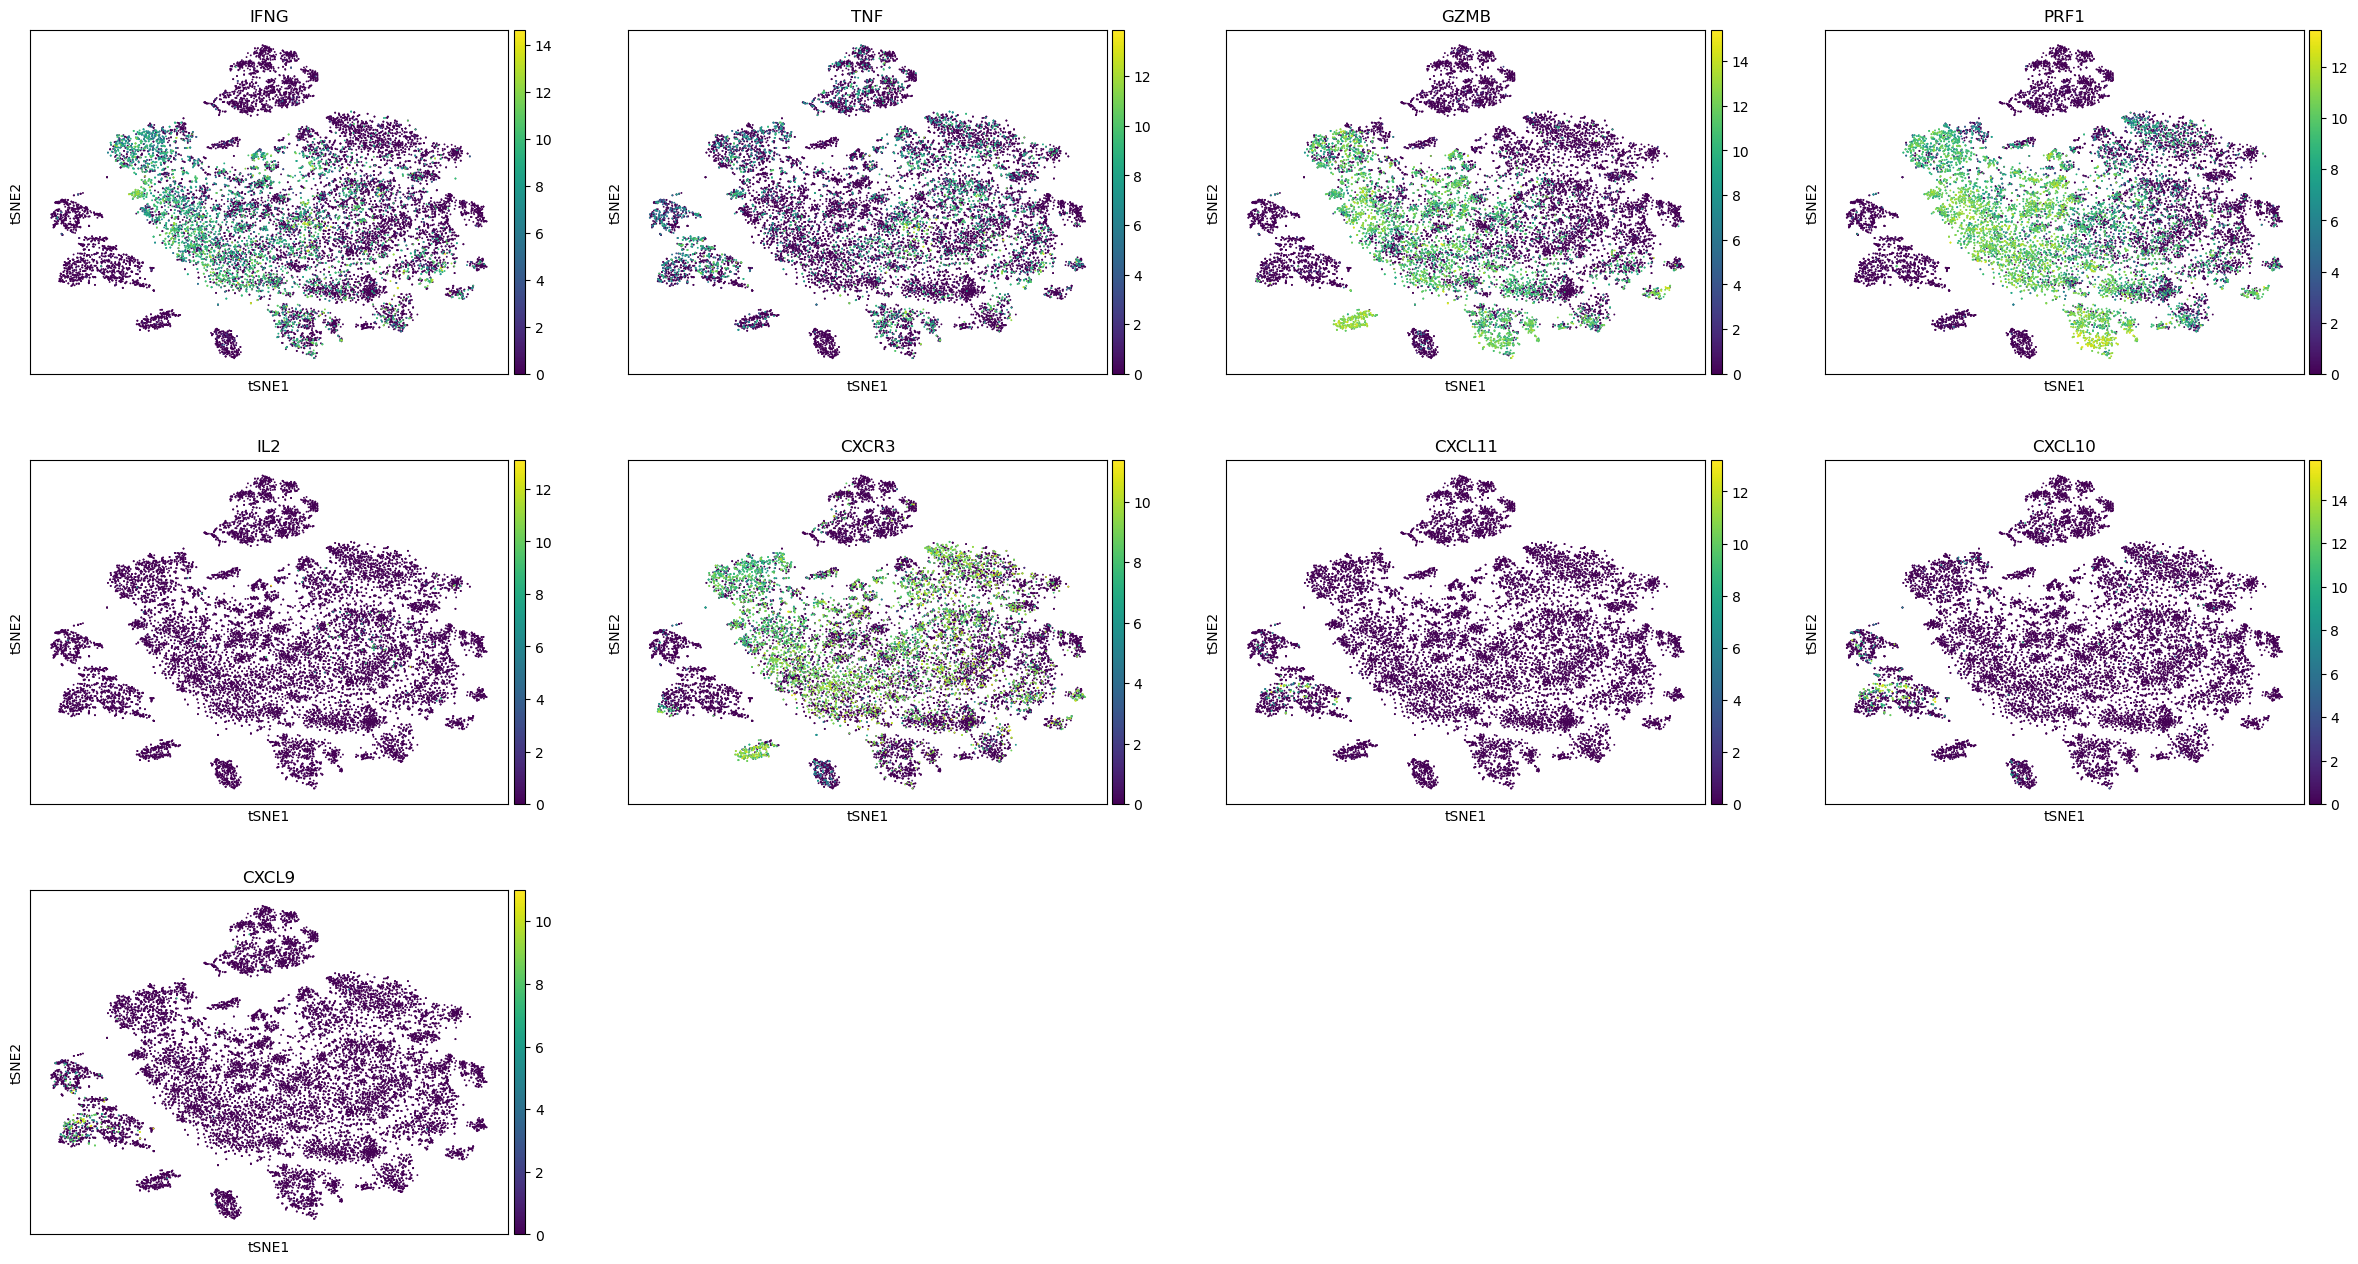

In [374]:
sc.pl.tsne(data, color = ['IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2', 'CXCR3', 'CXCL11', 'CXCL10', 'CXCL9'])

# Part 3 - use dropletseq to see how tumor cells express CXCR3 ligands

In [19]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/4.11.21/cohort_normalized_4.11.21_protein_coding_genes.pkl'

cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)

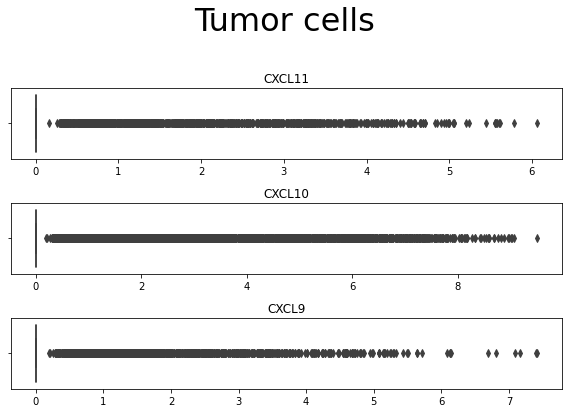

In [145]:
fig, axs = plt.subplots(3)
fig.set_size_inches(8, 6)

sns.reset_orig() # reset size of figure
genes = ['CXCL11', 'CXCL10', 'CXCL9']
for ii, gene in enumerate(genes):
    gene_idx = tumor_cohort.gene_names.index(gene)
    sns.boxplot(tumor_cohort.counts[:, gene_idx], ax=axs[ii]).set(title=gene);

fig.suptitle(f'Tumor cells', fontsize=32)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Part 4 - Treatment affects on CD8/CD4/CXCR3+ cells . 

In [76]:
gene_threshold = 2.5
CXCR3_pos = annCohort.X[:, annCohort.var.gene.tolist().index('CXCR3')] > gene_threshold

In [312]:
CD8 = ['CD8 Cytotoxic T cells' in ff for ff in annCohort.obs.cell_type]
CD4 = ['CD4 helper T cells' in ff for ff in annCohort.obs.cell_type]
response_list = annCohort.obs.response.tolist()
biopsy_time = annCohort.obs['pre/post'].tolist()
CXCR3_df = pd.DataFrame(transpose_list([response_list, biopsy_time, CD8, CD4, CXCR3_pos]), columns=['response', 'biopsy time', 'CD8','CD4', 'CXCR3'])


CXCR3_df['CD8+CXCR3+'] = CXCR3_df.CD8 & CXCR3_df.CXCR3
CXCR3_df['CD4+CXCR3+'] = CXCR3_df.CD4 & CXCR3_df.CXCR3
fraction_CXCR3_df = CXCR3_df.groupby(['response', 'biopsy time']).sum() / CXCR3_df.groupby(['response', 'biopsy time']).count()
fraction_CXCR3_df['% CD8+CXCR3+ (out of all CD8)'] = fraction_CXCR3_df['CD8+CXCR3+'] / fraction_CXCR3_df['CD8']
fraction_CXCR3_df['% CD4+CXCR3+ (out of all CD4)'] = fraction_CXCR3_df['CD4+CXCR3+'] / fraction_CXCR3_df['CD8']
fraction_CXCR3_df

CD8       CD4     CXCR3  CD8+CXCR3+  \
response      biopsy time                                             
Non-responder Post         0.377990  0.140218  0.362041    0.158426   
              Pre          0.454886  0.136435  0.304714    0.159226   
Responder     Post         0.360338  0.089116  0.199718    0.079958   
              Pre          0.376514  0.165505  0.221651    0.122202   

                           CD4+CXCR3+  % CD8+CXCR3+ (out of all CD8)  \
response      biopsy time                                              
Non-responder Post           0.060872                       0.419128   
              Pre            0.042772                       0.350034   
Responder     Post           0.025009                       0.221896   
              Pre            0.034128                       0.324561   

                           % CD4+CXCR3+ (out of all CD4)  
response      biopsy time                                 
Non-responder Post                              0.161041  
              Pre                               0.094029  
Responder     Post                              0.069404  
              Pre                               0.090643

Prints tabular data:

In [313]:
# print(f'Number of cells:')
# display(CXCR3_df.groupby(['response', 'biopsy time']).count().rename(columns={'CXCR3':'# cells'})[['# cells']])
# print(f'Number of those cells:')
# display(CXCR3_df.groupby(['response', 'biopsy time']).sum())
# print(f'% of these cells in cohort:')
# display(fraction_CXCR3_df)

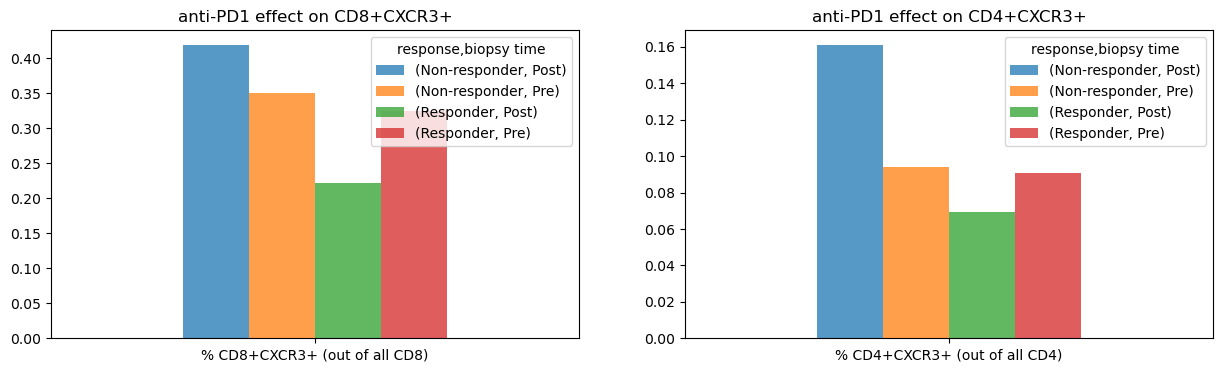

In [378]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 4)

pd.pivot_table(fraction_CXCR3_df, values='% CD8+CXCR3+ (out of all CD8)', columns=['response', 'biopsy time']).plot(kind = 'bar', ax=axs[0],title='anti-PD1 effect on CD8+CXCR3+', alpha=0.75, rot=0);
pd.pivot_table(fraction_CXCR3_df, values='% CD4+CXCR3+ (out of all CD4)', columns=['response', 'biopsy time']).plot(kind = 'bar', ax=axs[1],title='anti-PD1 effect on CD4+CXCR3+', alpha=0.75, rot=0);

##### Part B: How treatment affects expression of 'IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2' in different cell-types:

for 'IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2'
count how many CD8+CXCR3+ cells (in fraction) express all 5 genes, how many express 4, etc. An expression threshold of >2.5. 

In [365]:
gene_expressed_threshold = 2.5
interesting_genes =  ['IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2']
# interesting_genes =  ['CXCL9', 'CXCL10', 'CXCL11']

gene_indices = [annCohort.var.gene.tolist().index(ii) for ii in interesting_genes]
n_genes_exp = np.sum(annCohort.X[:, gene_indices] > gene_expressed_threshold, axis=1)
CXCR3_df['# cytokines'] = n_genes_exp

for ['IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2'] count how many CD8+CXCR3+ cells (in fraction) express all 5 genes, how many express 4, etc:


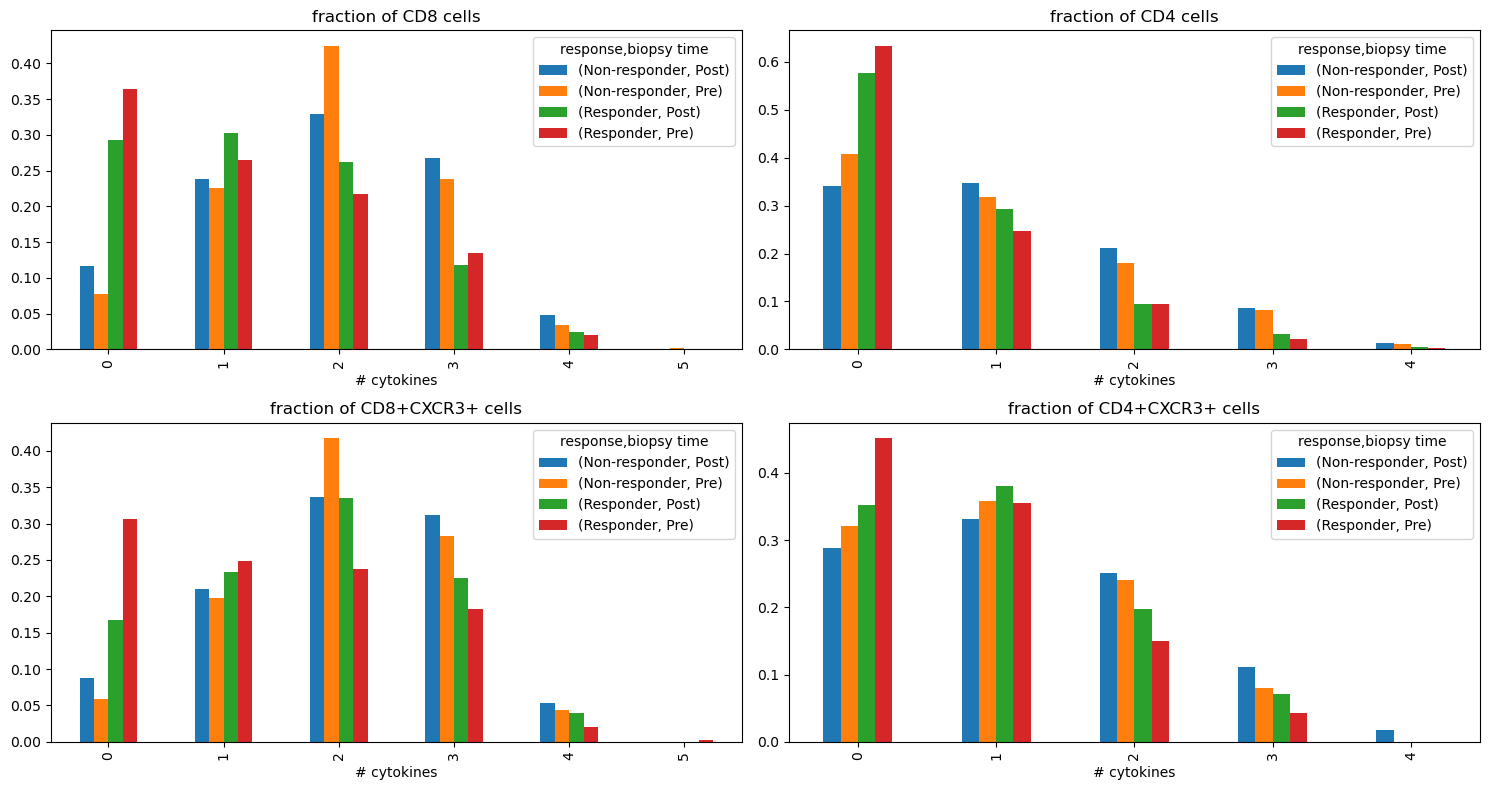

In [366]:
print(bold(f'for {interesting_genes} count how many CD8+CXCR3+ cells (in fraction) express all 5 genes, how many express 4, etc:'))
fig, axs = plt.subplots(2,2)
axs = axs.ravel()
fig.set_size_inches(15, 8)
cell_types_to_examine = ['CD8', 'CD4', 'CD8+CXCR3+','CD4+CXCR3+']
for curr_idx, cell_type in enumerate(cell_types_to_examine):
    n_genes_curr_celltype_df = CXCR3_df[CXCR3_df[cell_type]][['response', 'biopsy time', '# cytokines', cell_type]].groupby(['response', 'biopsy time', '# cytokines']).count().rename(columns={cell_type : f'# {cell_type}'})
    count_curr_celltype_CXCR3_df = CXCR3_df.groupby(['response', 'biopsy time']).sum()[[cell_type]]
    def get_num_of_cell_overall(x):
        return count_curr_celltype_CXCR3_df.loc[x.name[:2]].values[0]
    n_genes_curr_celltype_df['# total'] = n_genes_curr_celltype_df.apply(lambda x: get_num_of_cell_overall(x), axis=1)
    n_genes_curr_celltype_df['fraction'] = n_genes_curr_celltype_df[f'# {cell_type}'] / n_genes_curr_celltype_df['# total']
    pd.pivot_table(n_genes_curr_celltype_df[['fraction']].reset_index(), values='fraction', index=['# cytokines'],
                    columns=['response', 'biopsy time'], fill_value=0).plot(kind = 'bar',ax=axs[curr_idx], title=f'fraction of {cell_type} cells');
# axs[-1].remove()
fig.tight_layout()

# Debug

DEBUG:::: Part 3 - See fractions of CD8/CD4 cells (R/NR/ALL) that express one or more genes from ['IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2']
Fraction of cells expressing 1/2/3/4/5 genes from the gene list

In [16]:
gene_expressed_threshold = 2.5

In [17]:
CD8 = cohort.cells_information_list.get_cells_belong_to_cells_type('CD8 Cytotoxic T cells')
CD4 = cohort.cells_information_list.get_cells_belong_to_cells_type('CD4 helper T cells')

In [18]:
interesting_genes =  ['IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2']
gene_indices = [cohort.gene_names.index(ii) for ii in interesting_genes]

##### See fractions of CD8 R/NR/ALL that express one or more genes from ['IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2']

In [25]:
### CD8
CD8_filtered_genes = cohort.cells[CD8][:,gene_indices]
n_of_CD8_cells = len(CD8_filtered_genes)
fractions = dict(Counter((CD8_filtered_genes > gene_expressed_threshold).sum(axis=1)))
fractions = sort_dic({k: round(v/n_of_CD8_cells,4) for k,v in fractions.items()})
for i in range(6):
    fractions.setdefault(i, 0)
CD8_df = pd.DataFrame(({k: [v] for k,v in fractions.items()})).T.rename(columns={0:'CD8 Cytotoxic T cells'})


### CD8 responder
responder_patients = [cc.response_label==1 for cc in cohort.cells_information_list]
CD8_responder_filtered_genes = cohort.cells[np.array(responder_patients) & np.array(CD8)][:,gene_indices]
n_of_CD8_responder_cells = len(CD8_responder_filtered_genes)
fractions = dict(Counter((CD8_responder_filtered_genes > gene_expressed_threshold).sum(axis=1)))
fractions = sort_dic({k: round(v/n_of_CD8_responder_cells,4) for k,v in fractions.items()})
for i in range(6):
    fractions.setdefault(i, 0)
CD8_responder_df = pd.DataFrame(({k: [v] for k,v in fractions.items()})).T.rename(columns={0:'Responder - CD8 Cytotoxic T cells'})

### CD8 non-responder
non_responder_patients = [cc.response_label==0 for cc in cohort.cells_information_list]
CD8_non_responder_filtered_genes = cohort.cells[np.array(non_responder_patients) & np.array(CD8)][:,gene_indices]
n_of_CD8_non_responder_cells = len(CD8_non_responder_filtered_genes)
fractions = dict(Counter((CD8_non_responder_filtered_genes > gene_expressed_threshold).sum(axis=1)))
fractions = sort_dic({k: round(v/n_of_CD8_non_responder_cells,4) for k,v in fractions.items()})
for i in range(6):
    fractions.setdefault(i, 0)
CD8_non_responder_df = pd.DataFrame(({k: [v] for k,v in fractions.items()})).T.rename(columns={0:'Non responder - CD8 Cytotoxic T cells'})

CD8_fractions = pd.concat([CD8_df, CD8_non_responder_df, CD8_responder_df], axis=1)
CD8_fractions['# genes that are expressed'] = CD8_fractions.index.tolist()
CD8_fractions = CD8_fractions[['# genes that are expressed', 'CD8 Cytotoxic T cells', 'Responder - CD8 Cytotoxic T cells', 'Non responder - CD8 Cytotoxic T cells']]
CD8_fractions

# genes that are expressed  CD8 Cytotoxic T cells  \
0                           0                 0.1756   
1                           1                 0.2499   
2                           2                 0.3224   
3                           3                 0.2153   
4                           4                 0.0364   
5                           5                 0.0005   

   Responder - CD8 Cytotoxic T cells  Non responder - CD8 Cytotoxic T cells  
0                             0.3280                                 0.1030  
1                             0.2836                                 0.2339  
2                             0.2396                                 0.3618  
3                             0.1264                                 0.2576  
4                             0.0220                                 0.0432  
5                             0.0005                                 0.0005

In [ ]:
CD8_fractions.to_excel(r'/storage/md_keren/shitay/Nathi_project/CD8_fractions.xlsx', index = False)

##### See fractions of CD4 R/NR/ALL that express one or more genes in ['IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2']

In [27]:
CD4_filtered_genes = cohort.cells[CD4][:,gene_indices]
n_of_CD4_cells = len(CD4_filtered_genes)
fractions = dict(Counter((CD4_filtered_genes > gene_expressed_threshold).sum(axis=1)))
fractions = sort_dic({k: round(v/n_of_CD4_cells,4) for k,v in fractions.items()})
for i in range(6):
    fractions.setdefault(i, 0)
CD4_df = pd.DataFrame(({k: [v] for k,v in fractions.items()})).T.rename(columns={0:'CD4 helper T cells'})

### CD4 responder
responder_patients = [cc.response_label==1 for cc in cohort.cells_information_list]
CD4_responder_filtered_genes = cohort.cells[np.array(responder_patients) & np.array(CD4)][:,gene_indices]
n_of_CD4_responder_cells = len(CD4_responder_filtered_genes)
fractions = dict(Counter((CD4_responder_filtered_genes > gene_expressed_threshold).sum(axis=1)))
fractions = sort_dic({k: round(v/n_of_CD4_responder_cells,4) for k,v in fractions.items()})
for i in range(6):
    fractions.setdefault(i, 0)
CD4_responder_df = pd.DataFrame(({k: [v] for k,v in fractions.items()})).T.rename(columns={0:'Responder - CD4 helper T cells'})

### CD4 non-responder
non_responder_patients = [cc.response_label==0 for cc in cohort.cells_information_list]
CD4_non_responder_filtered_genes = cohort.cells[np.array(non_responder_patients) & np.array(CD4)][:,gene_indices]
n_of_CD4_non_responder_cells = len(CD4_non_responder_filtered_genes)
fractions = dict(Counter((CD4_non_responder_filtered_genes > gene_expressed_threshold).sum(axis=1)))
fractions = sort_dic({k: round(v/n_of_CD4_non_responder_cells,4) for k,v in fractions.items()})
for i in range(6):
    fractions.setdefault(i, 0)
CD4_non_responder_df = pd.DataFrame(({k: [v] for k,v in fractions.items()})).T.rename(columns={0:'Non responder - CD4 helper T cells'})


CD4_fractions = pd.concat([CD4_df, CD4_non_responder_df, CD4_responder_df], axis=1)
CD4_fractions['# genes that are expressed'] = CD4_fractions.index.tolist()
CD4_fractions = CD4_fractions[['# genes that are expressed', 'CD4 helper T cells', 'Responder - CD4 helper T cells', 'Non responder - CD4 helper T cells']]
CD4_fractions

# genes that are expressed  CD4 helper T cells  \
0                           0              0.4413   
1                           1              0.3142   
2                           2              0.1680   
3                           3              0.0665   
4                           4              0.0100   
5                           5              0.0000   

   Responder - CD4 helper T cells  Non responder - CD4 helper T cells  
0                          0.6136                              0.3599  
1                          0.2628                              0.3385  
2                          0.0952                              0.2024  
3                          0.0256                              0.0858  
4                          0.0028                              0.0134  
5                          0.0000                              0.0000

In [255]:
CD4_fractions.to_excel(r'/storage/md_keren/shitay/Nathi_project/CD4_fractions.xlsx', index = False)

# Debug

for ['IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2'] count how many CD8+CXCR3+ cells (in fraction) express all 5 genes, how many express 4, etc:


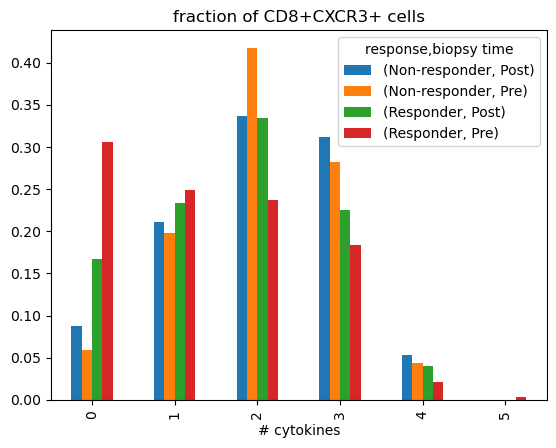

In [348]:
n_genes_CD8CXCR3_df = CXCR3_df[CXCR3_df['CD8+CXCR3+']][['response', 'biopsy time', '# cytokines', 'CD8+CXCR3+']].groupby(['response', 'biopsy time', '# cytokines']).count().rename(columns={'CD8+CXCR3+' : '# CD8+CXCR3+'})
count_CD8_CXCR3_df = CXCR3_df.groupby(['response', 'biopsy time']).sum()[['CD8+CXCR3+']]
def get_num_of_cell_overall(x):
    return count_CD8_CXCR3_df.loc[x.name[:2]].values[0]
n_genes_CD8CXCR3_df['# total'] = n_genes_CD8CXCR3_df.apply(lambda x: get_num_of_cell_overall(x), axis=1)
n_genes_CD8CXCR3_df['fraction'] = n_genes_CD8CXCR3_df['# CD8+CXCR3+'] / n_genes_CD8CXCR3_df['# total']
print(f'for {interesting_genes} count how many CD8+CXCR3+ cells (in fraction) express all 5 genes, how many express 4, etc:')

plt.rcdefaults()  
pd.pivot_table(n_genes_CD8CXCR3_df[['fraction']].reset_index(), values='fraction', index=['# cytokines'],
                    columns=['response', 'biopsy time'], fill_value=0).plot(kind = 'bar', title='fraction of CD8+CXCR3+ cells');

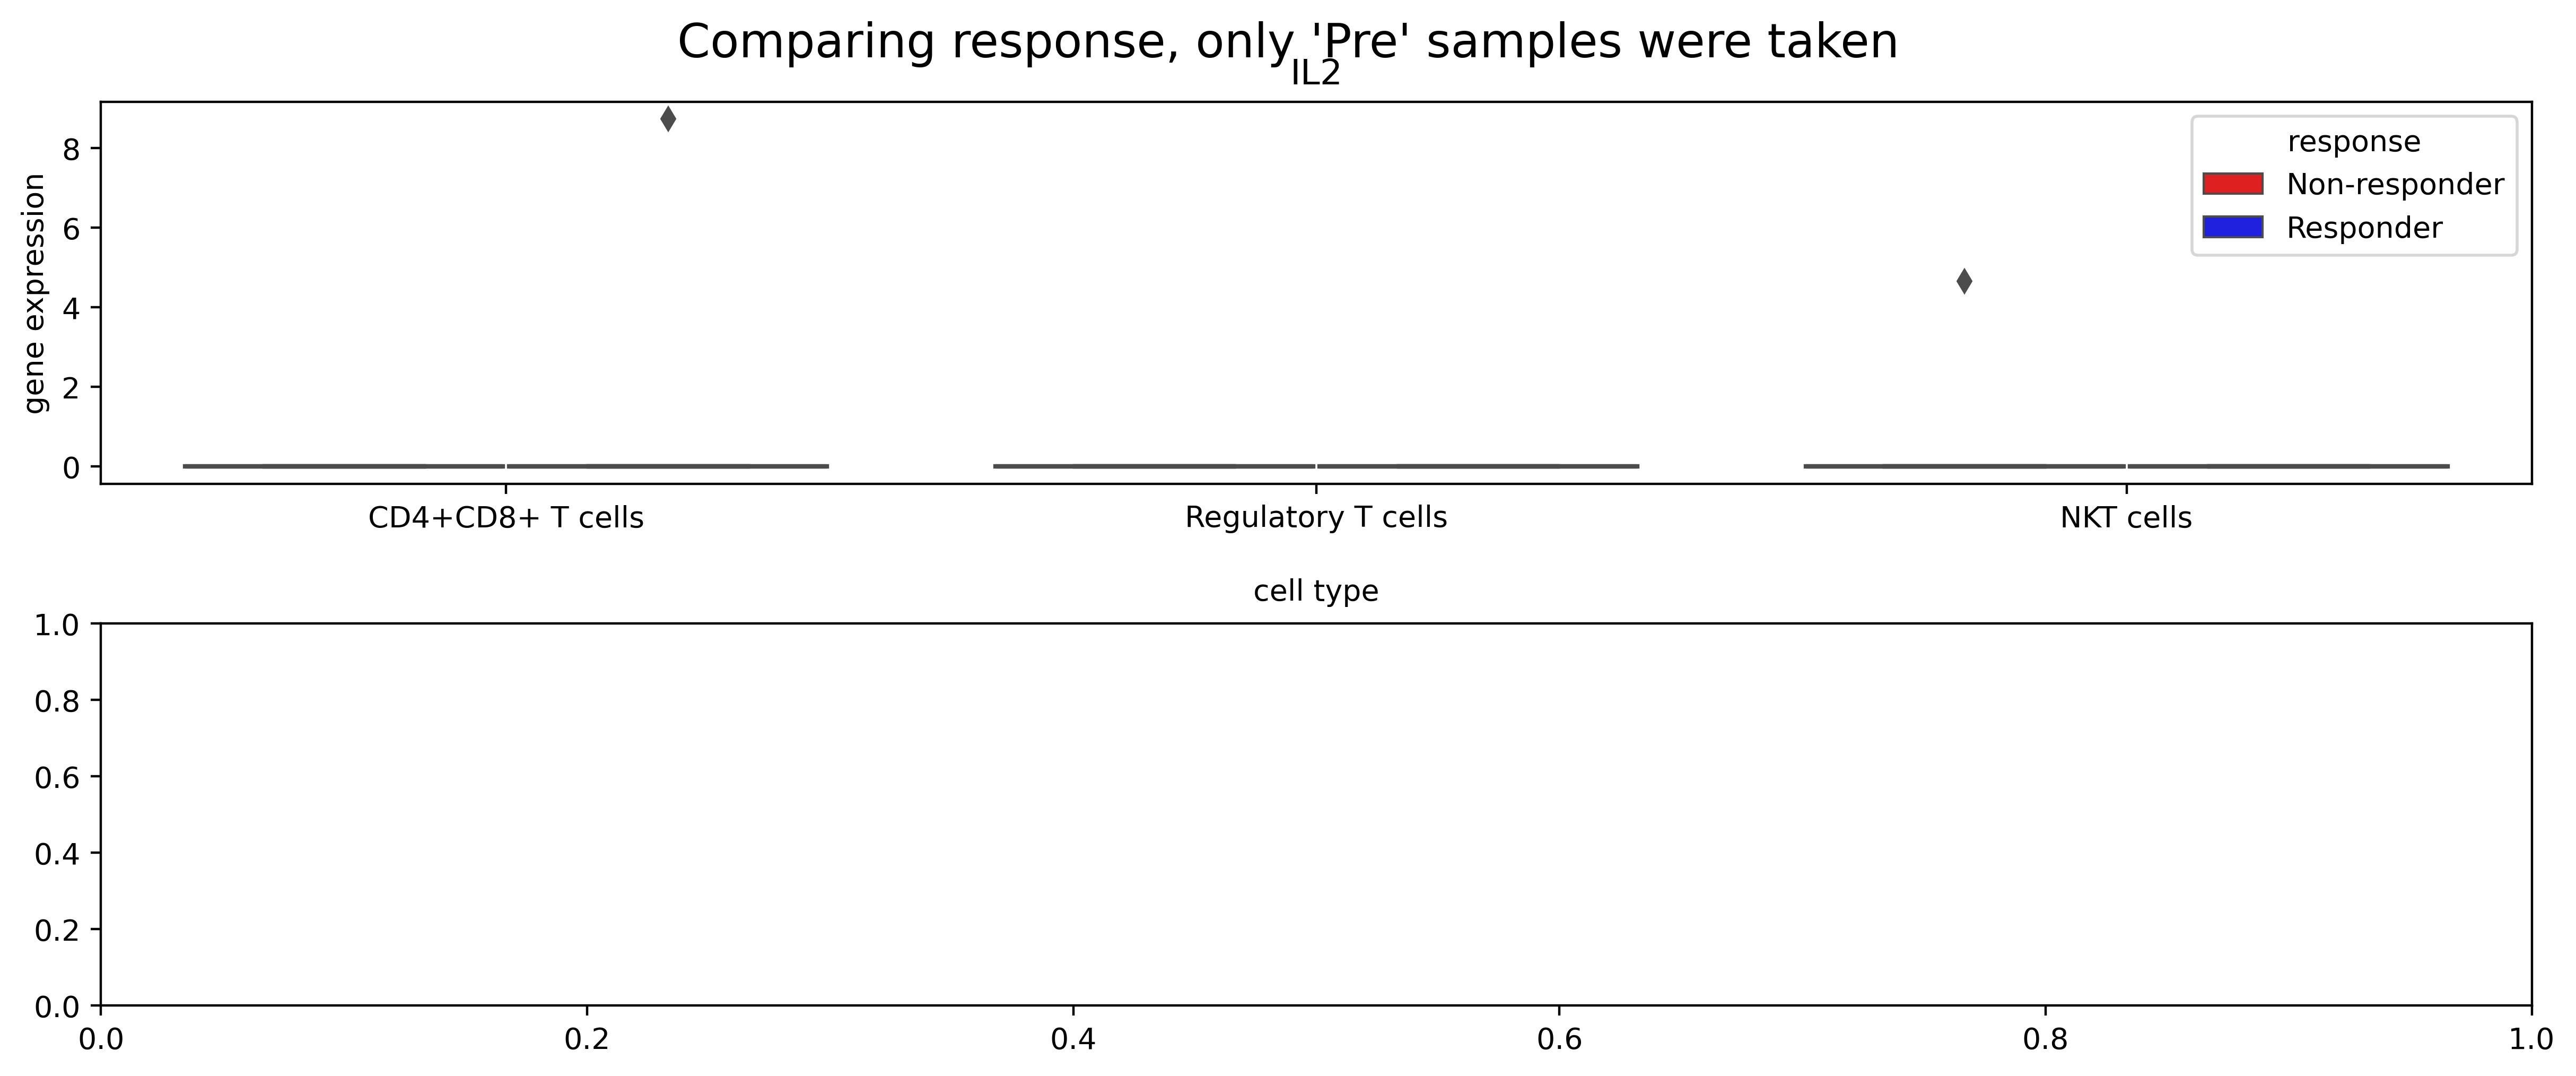

In [80]:
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 5)

### Correct pvals of all [genes X cell_types]
# corrected_pvals = multipletests_fdr(np.array([pp[1]for ct_dfs in df_gene_list.values() for pp in ct_dfs ]))[1].reshape(len(genes), len(CELL_TYPES))

# ### For each gene prints all cell types:
# for gene_idx, gene in enumerate(genes):
#     print_df = pd.DataFrame(columns=['barcode', 'gene expression', 'cell type', FEATURE])
#     for cell_idx, cell_type in enumerate(CELL_TYPES):
#         cell_type_df = df_gene_list[gene][cell_idx][0]
#         prev_pval = df_gene_list[gene][cell_idx][1]
#         corrected_pval = corrected_pvals[gene_idx][cell_idx]
#         cell_type_df['cell type'] = cell_type_df['cell type'].iloc[0]+'\n'+ get_pval_symbol(corrected_pval)
#         print_df = print_df.append(cell_type_df)

#     print_df['gene expression'] = print_df['gene expression'].astype(float)
#     g = sns.boxplot(ax=axs[gene_idx], x='cell type', y='gene expression', hue=FEATURE, data=print_df, palette="Set1").set(title=gene)
my_pal = {"Responder": "b", "Non-responder": "r", "Pre":"r", "Post":"b"}
g = sns.boxplot(ax=axs[0], x='cell type', y='gene expression', hue=FEATURE, data=print_df[:200], palette=my_pal).set(title=gene)
fig.suptitle(f'Comparing {FEATURE}, only \'{filter_feature_req_value}\' samples were taken', fontsize=16)
plt.tight_layout(pad=0.2)

In [1]:
ddd = pickle.load(open(r'/storage/md_keren/shitay/Data/smart_seq/patients_divisions/all_test0.3_ver2.p', 'rb'))
len(ddd)

NameError: name 'pickle' is not defined

In [38]:
cell_type = 'Neutrophils'
sum([cell_type in cc.supervised for cc in cohort.cells_information_list])

40

In [5]:
n_cell_df = pd.DataFrame([list(dd) for dd in list(Counter([cc.patient_details for cc in cohort.cells_information_list]).items())],
                         columns=['sample','n_cells']).set_index('sample')
# n_cell_df

In [6]:
FEATURE = 'pre/post' # "response" or "pre/post"
TEST_NAME = 'FRACTION' # FRACTION/Z/FISHER


if TEST_NAME=='FRACTION':
    stat_test = fraction_test
elif TEST_NAME=='Z':
    stat_test = Z_TEST
elif TEST_NAME=='FISHER':
    stat_test = fisher_test
else:
    raise Exception('statistical name is not valid, change it')


In [12]:
gene = 'CXCL10'
cell_type = 'Neutrophils'

g_cohort = annCohort[:,  annCohort.var['gene']==gene]
f_df = pd.DataFrame(columns=['barcode', 'gene expression', 'cell type', FEATURE])
indices = [cell_type in ttt for ttt in g_cohort.obs['cell_type']]
fg_cohort = g_cohort[indices, :]
gene_exps = fg_cohort.X[:,0].tolist()
feature_values = fg_cohort.obs[FEATURE].tolist()
samples = fg_cohort.obs['sample'].tolist()

### statistical test of gene expression R/NR
res_df = pd.DataFrame(transpose_list([samples, feature_values, gene_exps]), columns=['sample', FEATURE, 'exp'])
pvalue = stat_test(res_df, FEATURE, gene, cell_type)

pvalue


0.2967175263220605

In [45]:
# sum([cell_type in cc.supervised for cc in cohort.cells_information_list])
gg = fractions.sort_values('fractions').reset_index()
gg['n_cells_expressing_gene'] = gg['sum']
gg['n_cells_of_current_cell_type'] = gg['count']
# fractions
gg = gg[['sample', 'pre/post', 'n_cells_expressing_gene', 'n_cells_of_current_cell_type', 'fractions']] 
gg
# sum(df_expression['is_expressing'])

sample pre/post  n_cells_expressing_gene  n_cells_of_current_cell_type  \
0     Post_P5     Post                        0                             1   
1     Pre_P12      Pre                        0                             1   
2     Pre_P15      Pre                        0                             2   
3    Post_P28     Post                        3                            15   
4  Post_P28_2     Post                        2                             8   
5      Pre_P4      Pre                        9                            11   
6    Post_P23     Post                        1                             1   
7     Post_P8     Post                        1                             1   

   fractions  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.200000  
4   0.250000  
5   0.818182  
6   1.000000  
7   1.000000

In [29]:
df_expression = res_df
values_in_feature = list(set(df_expression[FEATURE]))
if len(values_in_feature) < 2:
    print(f'no cells in one of the groups for: {gene}, {cell_type}')
    print('1')
else:
    val_1 = values_in_feature[0]
    val_2 = values_in_feature[1]

    if len(df_expression[df_expression[FEATURE]==val_1])<=5 or len(df_expression[df_expression[FEATURE]==val_2])<=5:
        print('2')
    else:
        print('3')
        df_expression['is_expressing'] = df_expression.exp >2.5
        fractions = df_expression.groupby(['sample', FEATURE])['is_expressing'].agg(['sum', 'count']).reset_index()
#         fractions['n_cells_in_sample'] = fractions['sample'].apply(lambda x: n_cell_df.loc[x])
        fractions['fractions'] = fractions['sum']/fractions['count']
        statistic, pvalue = ranksums(fractions[fractions[FEATURE]==val_2].fractions, fractions[fractions[FEATURE]==val_1].fractions)
        
pvalue

3


0.2967175263220605

In [16]:
n_cell_df

n_cells
sample             
Pre_P1          229
Post_P1         291
Post_P1_2       353
Pre_P2          337
Post_P2         380
Pre_P3          245
Post_P3         359
Post_P3_2       358
Pre_P4          311
Post_P4         675
Post_P5         292
Post_P5_2       336
Pre_P6          288
Post_P6         400
Pre_P7          368
Post_P7         231
Pre_P8          267
Post_P8         409
Post_P10        396
Post_P11        313
Pre_P12         330
Post_P12        323
Post_P13        449
Post_P14        329
Pre_P15         304
Post_P15        304
Post_P16        463
Post_P17        281
Post_P18        357
Post_P19        403
Pre_P20         323
Post_P20        358
Post_P21        213
Post_P22        260
Post_P23        358
Post_P23_2      362
Pre_P24         338
Pre_P25         371
Pre_P26         333
Pre_P27         343
Pre_P28         337
Post_P28        369
Post_P28_2      372
Pre_P29         163
Post_P30        369
Pre_P31         351
Pre_P33         452
Pre_P35         238

n_cells
0      358
1      369
2      372
3      292
4      409
5      330
6      304
7      311

In [263]:
fractions
df_expression
len(res_df)

40

In [45]:
df = pd.DataFrame({'state': ['CA', 'WA', 'CO', 'AZ'] * 3,
                   'office_id': list(range(1, 7)) * 2,
                   'sales': [np.random.randint(100000, 999999)
                             for _ in range(12)]})
state_office = df.groupby(['state', 'office_id']).agg({'sales': 'sum'})
# Change: groupby state_office and divide by sum
state_pcts = state_office.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
# state_office

In [41]:
state_pcts.head()

is_expressing
samples                
Post_P1           100.0
Post_P10          100.0
Post_P11            NaN
Post_P12            NaN
Post_P13            NaN

In [45]:
def fraction_test(df_expression):
    # return pval
    if len(df_expression[df_expression.response=='Responder'])<=5 or len(df_expression[df_expression.response=='Non-responder'])<=5:
        return 1
    df_expression['is_expressing'] = df_expression.exp >2.5
    fractions = df_expression.groupby(['sample', 'response'])['is_expressing'].agg(['sum', 'count']).reset_index()
    fractions['fractions'] = fractions['sum']/fractions['count']
    statistic, pvalue = ranksums(fractions[fractions['response']=='Non-responder'].fractions, fractions[fractions['response']=='Responder'].fractions)
    return pvalue



In [92]:
"""
1. Using fisher's exact test
2. patient fraction test
"""

# statistic, pvalue = ztest(res_df[res_df.response=='Responder'].exp, res_df[res_df.response=='Non-responder'].exp, value=0) 
# res_df[res_df.response=='Non-responder']

# res_df.groupby(['samples', 'is_expressing']).count()

"\n1. Using fisher's exact test\n2. patient fraction test\n"

In [48]:

# stat_test(res_df)

In [49]:
# The rule is * for p<0.05, ** for p<0.005 and *** for p<0.0005.

def get_pval_symbol(p):
    if p<0.0005:
        return '***'
    elif p<0.005:
        return '**'
    elif p<0.05:
        return '*'
    else:
        return ''

### builds DFs of all genes X cell types and conduct Z test:
df_gene_list = {}
for gene_idx, gene in enumerate(genes):
    g_cohort = annCohort[:,  annCohort.var['gene']==gene]
    f_df = pd.DataFrame(columns=['barcode', 'gene expression', 'cell type', 'Response'])
    df_gene_list[gene] = []
    for idx, cell_type in enumerate(cell_types):
        indices = [cell_type in ttt for ttt in g_cohort.obs['cell_type']]
        fg_cohort = g_cohort[indices, :]
        gene_exps = fg_cohort.X[:,0].tolist()
        responses = fg_cohort.obs['response'].tolist()
        barcodes = fg_cohort.obs['barcode'].tolist()
        samples = fg_cohort.obs['sample'].tolist()
        
        ### ztest on gene expression R/NR
        res_df = pd.DataFrame(transpose_list([samples, responses, gene_exps]), columns=['sample', 'response', 'exp'])
        pvalue = stat_test(res_df)
    
        df_gene_list[gene].append([pd.DataFrame(np.array([barcodes, gene_exps, [cell_type]*fg_cohort.shape[0], responses]).T, columns=f_df.columns), pvalue])
        
fig, axs = plt.subplots(len(genes))
fig.set_size_inches(32, 30)

### Correct pvals of all [genes X cell_types]
corrected_pvals = multipletests_fdr(np.array([pp[1]for ct_dfs in df_gene_list.values() for pp in ct_dfs ]))[1].reshape(len(genes), len(cell_types))

### For each gene prints all cell types:
for gene_idx, gene in enumerate(genes):
    print_df = pd.DataFrame(columns=['barcode', 'gene expression', 'cell type', 'Response'])
    for cell_idx, cell_type in enumerate(cell_types):
        cell_type_df = df_gene_list[gene][cell_idx][0]
        prev_pval = df_gene_list[gene][cell_idx][1]
        corrected_pval = corrected_pvals[gene_idx][cell_idx]
        cell_type_df['cell type'] = cell_type_df['cell type'].iloc[0]+'\n'+ get_pval_symbol(corrected_pval)
        print_df = print_df.append(cell_type_df)

    print_df['gene expression'] = print_df['gene expression'].astype(float)
    g = sns.boxplot(ax=axs[gene_idx], x='cell type', y='gene expression', hue='Response', data=print_df, palette="Set1").set(title=gene)

plt.tight_layout(pad=0.2)

In [24]:
# cohort.cells_information_list[10].supervised

In [17]:
# patient: patient_details
# barcode: cell_id
# supervised



samples = [cc.patient_details for cc in cohort.cells_information_list]
barcodes = [cc.cell_id for cc in cohort.cells_information_list]
cell_types = [cc.supervised for cc in cohort.cells_information_list]
    
df = pd.DataFrame(transpose_list([samples, barcodes, cell_types]), columns=['sample_id', 'barcode', 'cell_types'])
df.to_excel(r'/storage/md_keren/shitay/garbage/sapir_df.xlsx', index=False)

In [ ]:
########################## WITHOUT Z TEST ON GENE EXPRESSION ##########################

# fig, axs = plt.subplots(len(genes))
# fig.set_size_inches(28, 30)


# for gene_idx, gene in enumerate(genes):
#     g_cohort = annCohort[:,  annCohort.var['gene']==gene]
#     df = pd.DataFrame(columns=['barcode', 'gene expression', 'cell type', 'Response'])
#     for idx, cell_type in enumerate(cell_types):
#         indices = [cell_type in ttt for ttt in g_cohort.obs['cell_type']]
#         fg_cohort = g_cohort[indices, :]
#         gene_exps = fg_cohort.X[:,0].tolist()
#         responses = fg_cohort.obs['response'].tolist()
#         barcodes = fg_cohort.obs['barcode'].tolist()
#         df = df.append(pd.DataFrame(np.array([barcodes, gene_exps, [cell_type]*fg_cohort.shape[0], responses]).T, columns=df.columns))
#     df['gene expression'] = df['gene expression'].astype(float)
#     g = sns.boxplot(ax=axs[gene_idx], x='cell type', y='gene expression', hue='Response', data=df, palette="Set1").set(title=gene)

# plt.tight_layout(pad=0.2)




In [116]:
########################## Z test without pvals corrections ##########################

# fig, axs = plt.subplots(len(genes))
# fig.set_size_inches(32, 30)

# def get_pval_symbol(p):
#     if p<0.0005:
#         return '***'
#     elif p<0.005:
#         return '**'
#     elif p<0.05:
#         return '*'
#     else:
#         return ''

# for gene_idx, gene in enumerate(genes):
#     g_cohort = annCohort[:,  annCohort.var['gene']==gene]
#     df = pd.DataFrame(columns=['barcode', 'gene expression', 'cell type', 'Response'])
#     for idx, cell_type in enumerate(cell_types):
#         indices = [cell_type in ttt for ttt in g_cohort.obs['cell_type']]
#         fg_cohort = g_cohort[indices, :]
#         gene_exps = fg_cohort.X[:,0].tolist()
#         responses = fg_cohort.obs['response'].tolist()
#         barcodes = fg_cohort.obs['barcode'].tolist()
        
#         ### ztest on gene expression R/NR
#         res_df = pd.DataFrame(transpose_list([responses, gene_exps]), columns=['response', 'exp'])
#         if len(res_df[res_df.response=='Responder'])>5 and len(res_df[res_df.response=='Non-responder'])>5:
#             statistic, pvalue = ztest(res_df[res_df.response=='Responder'].exp, res_df[res_df.response=='Non-responder'].exp, value=0) 
#         else:
#             pvalue = 1
#         pval_sym = get_pval_symbol(pvalue)
    
#         df = df.append(pd.DataFrame(np.array([barcodes, gene_exps, [cell_type+'\n'+pval_sym]*fg_cohort.shape[0], responses]).T, columns=df.columns))
        
#     df['gene expression'] = df['gene expression'].astype(float)
#     g = sns.boxplot(ax=axs[gene_idx], x='cell type', y='gene expression', hue='Response', data=df, palette="Set1").set(title=gene)

# plt.tight_layout(pad=0.2)

In [ ]:
# I would add IFNG, TNFA, GZMB, PRF1 and IL2 (not sure if PRF appears as PRF or PRF1).
### Fine: IFNG, GZMB, PRF1, IL2

 
gene = 'PRF1'
genes = ['IFNG', 'TNFA', 'GZMB', 'PRF1', 'IL2']

annCohort[:,10].obs['response']=='Responder'

In [71]:
# gene = 'CXCL10'
# [gg for gg in cohort.gene_names if gg in gene]

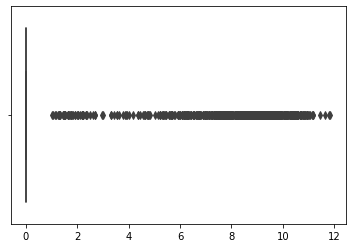

In [61]:
sns.reset_orig() # reset size of figure

sns.boxplot(x=cohort.cells[:,gene_indices[0]]);

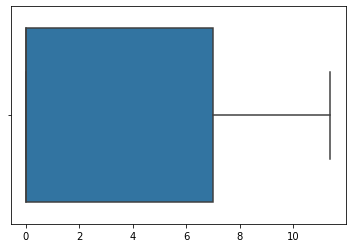

In [62]:
sns.boxplot(x=cohort.cells[:,gene_indices[1]]);